## D - Informative data summaries

Authors: Noemi Anau Montel, James Alvey, Christoph Weniger

Last update: 15 September 2023

**Purpose**: Illustration of how meaningful data summaries can emerge automatically depending on the network architecture.

**Key take-away messages**: Data summaries are automatically learned when introducing an information bottleneck in the network. Those summaries are easier to interpret than dense networks.

### Code

In [1]:
import numpy as np
import pylab as plt
import torch
import swyft
DEVICE = 'gpu' if torch.cuda.is_available() else 'cpu'

In [2]:
torch.manual_seed(0)
np.random.seed(0)

We consider the same linear regression problem as above.

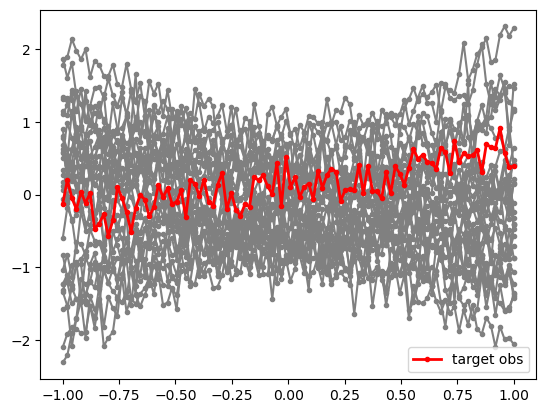

In [3]:
N = 10_000  # Number of samples
Nbins = 100
z = np.random.rand(N, 3)*2 - 1
y = np.linspace(-1, 1, Nbins)
m = np.ones_like(y)*z[:,:1] + y*z[:,1:2] + y**2*z[:,2:]
x = m + np.random.randn(N, Nbins)*0.2 #+ np.random.poisson(lam = 3/Nbins, size = (N, Nbins))*5

# We keep the first sample as observation, and use the rest for training
samples = swyft.Samples(x = x[1:], z = z[1:])
obs = swyft.Sample(x = x[0], z = z[0])

# Visualization
for i in range(30):
    plt.plot(y, samples[i]['x'], marker='.', color='0.5')
plt.plot(y, obs['x'], marker='.', color='r', lw = 2, label = 'target obs')
plt.legend(loc=0)

However, instead of directly passing the entire data vector to the dense regression network, we first perform data compression using a simple compression network. During training, this network learns to generate informative data summaries `s`.

As compression network, we use a single linear layer
$$
\mathbf s = W \mathbf x + \mathbf b
$$
where $W$ is a $3\times 100$ matrix, and $\mathbf b$ a bias vector of length three.

In [4]:
class Network(swyft.SwyftModule):
    def __init__(self):
        super().__init__()
        self.summarizer = torch.nn.Linear(Nbins, 3)
        self.logratios = swyft.LogRatioEstimator_1dim(num_features = 1, num_params = 3, varnames = 'z')

    def forward(self, A, B):
        s = self.summarizer(A['x'])
        s = s.unsqueeze(-1)
        return self.logratios(s, B['z']), s

Training proceeds as usual. Note that in the above inference network we return  the data summaries `s` besides the logratio estimator.  This is convenient for later inspection.  Anything that is not of type `swyft.LogRatioSamples` is automatically ignored during training.

In [5]:
trainer = swyft.SwyftTrainer(accelerator = DEVICE, precision = 64)
dm = swyft.SwyftDataModule(samples)
network = Network()
trainer.fit(network, dm)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/cweniger/opt/anaconda3/envs/native2/lib/python3.9/site-packages/pytorch_lightning/trainer/setup.py:200: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(
/Users/cweniger/opt/anaconda3/envs/native2/lib/python3.9/site-packages/pytorch_lightning/loops/utilities.py:94: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint

  | Name       | Type                   | Params
------------------------------------------------------
0 | summarizer | Linear                 | 303   
1 | logratios  | LogRatioEstimator_1dim | 52.

Sanity Checking: 0it [00:00, ?it/s]

/Users/cweniger/opt/anaconda3/envs/native2/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/cweniger/opt/anaconda3/envs/native2/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Reloading best model: /Users/cweniger/Documents/swyft/notebooks/lightning_logs/version_19/checkpoints/epoch=4-step=1250.ckpt


What data summaries were learned?  It is instructive to plot the three rows of the weight matrix $W$. (The bias vector $\mathbf b$ just provides a linear shift to the summary $\mathbf s$ and is here less interesting.)

Mean weight for z[0]: -0.03758
Mean weight for z[1]: 0.00016
Mean weight for z[2]: 0.00048


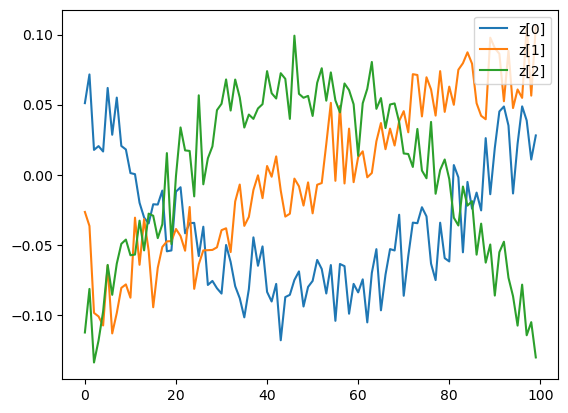

In [6]:
weight = network.summarizer.state_dict()['weight']
for i in range(3):
  plt.plot(weight[i], label='z[%i]'%i);
  print("Mean weight for z[%i]: %.5f"%(i, weight[i].mean().item()))
plt.legend(loc=1);

We see that the second component, `z[1]`, indeed picks up linear trends, whereas the first component `z[0]` has an around 1000 times larger mean value (picking up the constant term), and the `z[2]` components picks up quadractic trends. So the summaries indeed are reasonable (although, due to the quick-and-dirty training strategy that we used, they could be further improved).

Inference is done as before, now targeting the mock observation from above. We plot the three one-dimensional posteriors side by side.

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint


Predicting: 250it [00:00, ?it/s]

/Users/cweniger/opt/anaconda3/envs/native2/lib/python3.9/site-packages/pytorch_lightning/loops/epoch/prediction_epoch_loop.py:173: UserWarning: Lightning couldn't infer the indices fetched for your dataloader.
  warning_cache.warn("Lightning couldn't infer the indices fetched for your dataloader.")


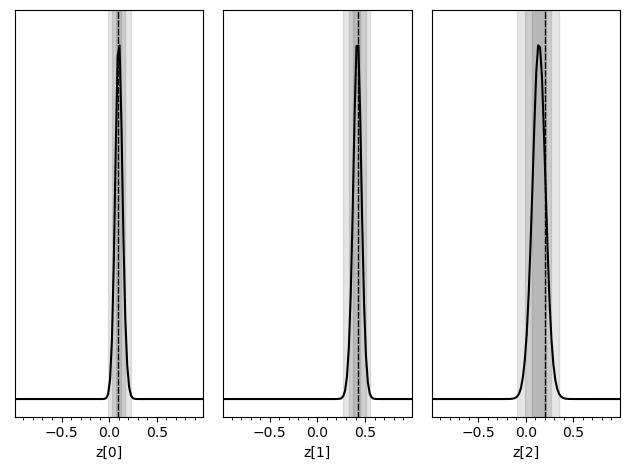

In [7]:
prior_samples = swyft.Samples(z = np.random.rand(100_000, 3)*2-1)
predictions = trainer.infer(network, obs, prior_samples)

truth = {k: v for k, v in zip(["z[%i]"%i for i in range(3)], obs['z'])}
swyft.plot_posterior(predictions, ["z[%i]"%i for i in range(3)], truth=truth)

We (should) see that the posteriors are now narrower than the ones obtained in the previous exercise without explicit data compression. In general, it is often useful to compress high-dimensional data into low-dimensional data summaries before comparing them with model parameters.

Finally, let us confirm that the data summaries indeed are trained such that they become correlated with the parameters of interest. To this end, we can extract the summaries by running `infer` again, and exploit that inference networks can return auxiliary information (in this case the data summary).

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint


Predicting: 250it [00:00, ?it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint


Predicting: 250it [00:00, ?it/s]

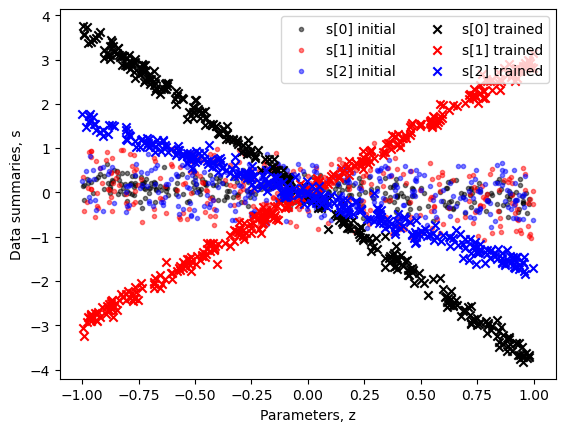

In [8]:
pred_untrained = trainer.infer(Network(), samples[:300], samples[:300], return_sample_ratios = False, batch_size = 1)
pred_trained = trainer.infer(network, samples[:300], samples[:300], return_sample_ratios = False, batch_size = 1)
Z = []; S = []
for i in range(len(pred_untrained)):
    s1 = pred_untrained[i][1][0,:,0].numpy()
    z1 = pred_untrained[i][0].params.numpy()[0,:,0]
    s2 = pred_trained[i][1][0,:,0].numpy()
    z2 = pred_trained[i][0].params.numpy()[0,:,0]
    Z.append([z1, z2]); S.append([s1, s2])
Z = np.array(Z); S = np.array(S)
plt.scatter(Z[:,0,0], S[:,0,0], color='k', label='s[0] initial', marker='.', alpha = 0.5);
plt.scatter(Z[:,0,1], S[:,0,1], color='r', label='s[1] initial', marker='.', alpha = 0.5);
plt.scatter(Z[:,0,2], S[:,0,2], color='b', label='s[2] initial', marker='.', alpha = 0.5);
plt.scatter(Z[:,1,0], S[:,1,0], color='k', label='s[0] trained', marker='x');
plt.scatter(Z[:,1,1], S[:,1,1], color='r', label='s[1] trained', marker='x');
plt.scatter(Z[:,1,2], S[:,1,2], color='b', label='s[2] trained', marker='x');
plt.xlabel("Parameters, z");
plt.ylabel("Data summaries, s")
plt.legend(loc=1, ncol = 2);

### Exercises

1. Switch on non-gaussian noise in the above example and retrain the network.
- How do the data summaries change?
- How do the posteriors change?
- How does they compare to the posteriors of the previous example with non-Gaussian noise, but without compression network?
- Why is the linear data summary less efficient in the presence of non-Gaussian noise?

In [9]:
# Your results go here